In [1]:
#importing libaries and initialising my network
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import plotly.graph_objects as go
#from plotly.colors import n_colorsy
import Deep_Neural_Network_Script
import mpmath
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

torch.cuda.empty_cache()

device = torch.device("cpu")





poly_model = Deep_Neural_Network_Script.DeepNeural(
    n_inputs = 1,
    n_hidden = 1000,
    n_layers = 2, 
    n_outputs = 1,
    activation = 'gelu',
    device_used=device
)




In [2]:
#collecting data from csv file
file_name_I1 = 'GlobalTemperatures.csv'
I1_data = pd.read_csv(file_name_I1)
Cummulative_days = I1_data['days ']
Mean_temp = I1_data['Land Average Temperature']
Mean_temp_uncertainty = I1_data['Temp uncertainty']
I1_data.head()



,date,month,year,days,Land Average Temperature,Temp uncertainty,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,1750-01-01,1,1750,30,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,2,1750,60,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,3,1750,90,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,4,1750,120,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,5,1750,150,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print(len(Mean_temp))

3180


In [4]:
Cleaned_mean_temp = []
Cleaned_cummulative_days = []
for i in range(int(len(Mean_temp)/12)):
    Cleaned_mean_temp.append(sum(Mean_temp[12*i: 12*(i+1)])/12)
    Cleaned_cummulative_days.append(sum(Cummulative_days[12*i: 12*(i+1)])/12)
#disregarding pre 1850 data due to unreliablily and noise
Cleaned_cummulative_days = np.array(Cleaned_cummulative_days[128:])
Cleaned_mean_temp = np.array(Cleaned_mean_temp[128:])

x_data = (np.array(Cleaned_cummulative_days)-min(Cleaned_cummulative_days))/(max(Cleaned_cummulative_days)-min(Cleaned_cummulative_days))
y_data = (np.array(Cleaned_mean_temp)-min(Cleaned_mean_temp))/(max(Cleaned_mean_temp)-min(Cleaned_mean_temp))

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

x_train_tensor = torch.tensor(x_train, dtype = torch.float32).unsqueeze(-1).to(poly_model.device_used)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32).unsqueeze(-1).to(poly_model.device_used)
x_test_tensor = torch.tensor(x_test, dtype = torch.float32).unsqueeze(-1).to(poly_model.device_used)
y_test_tensor = torch.tensor(y_test, dtype = torch.float32).unsqueeze(-1).to(poly_model.device_used)


#batch the data
batch_size = 10 #1000

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)



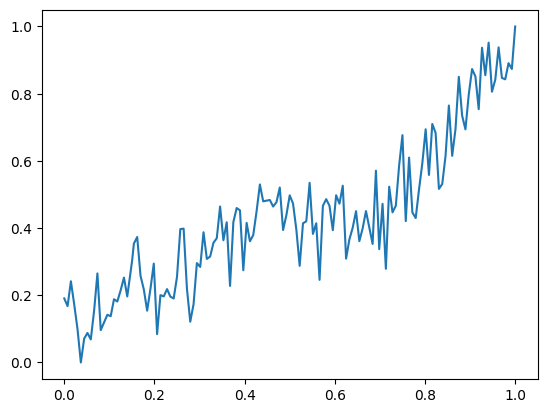

In [5]:
plt.plot(x_data, y_data)

In [6]:
#training the model
num_epochs = 2000#10000
#batch_size = 100
freq = 20#size of each array collected below
loss_array, iteration_array, val_loss_array, lr_array = np.zeros(int(freq)), np.zeros(int(freq)), np.zeros(int(freq)), np.zeros(int(freq))
i_indication = 0
collection_rate = int(num_epochs/(freq))
loss_function = nn.MSELoss()#Deep_Neural_Network_Script.RMSLELoss()
weight_decay = 1e-5 # l2 regularisation 1e-4
optimizer = optim.Adam(poly_model.parameters(), lr =0.001, weight_decay=weight_decay)#



for epoch in range(num_epochs):
    for batch in train_loader:
        x, y = batch

        optimizer.zero_grad()
        #forward
        y_pred = poly_model.forward(x)
        loss = loss_function(y_pred, y)

        #backward
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % collection_rate == 0: #10000   
        poly_model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_test in test_loader:
                x_tes, y_tes = batch_test
                test_outputs = poly_model.forward(x_tes)
                val_loss += loss_function(test_outputs, y_tes)
            val_loss = val_loss/len(test_loader)
            
            #plt.plot(normalised_Cummulative_days, poly_model.forward(torch.tensor(normalised_Cummulative_days, dtype = torch.float32).reshape(-1,1,1)).detach().numpy(), color = "red", label = "RNN")
            #plt.plot(normalised_Cummulative_days, normalised_Mean_temp, color = 'blue', label = "actual temp")
            #plt.legend()
            #plt.show()
            #scheduler room 
            print(f'Epoch  [{epoch+1}/{num_epochs}],   Loss: {loss.item():.8f} ,   Val Loss: {val_loss.item():.8f}')
            loss_array[i_indication] = loss
            val_loss_array[i_indication] = val_loss
            iteration_array[i_indication] = epoch + 1
            i_indication = i_indication + 1
            
       
        poly_model.train()
        




Epoch  [100/2000],   Loss: 0.01250239 ,   Val Loss: 0.00664926
Epoch  [200/2000],   Loss: 0.01107170 ,   Val Loss: 0.00632064
Epoch  [300/2000],   Loss: 0.01033699 ,   Val Loss: 0.00614795
Epoch  [400/2000],   Loss: 0.00214532 ,   Val Loss: 0.00787135
Epoch  [500/2000],   Loss: 0.00104686 ,   Val Loss: 0.00555218
Epoch  [600/2000],   Loss: 0.00231508 ,   Val Loss: 0.00604797
Epoch  [700/2000],   Loss: 0.00739668 ,   Val Loss: 0.00538877
Epoch  [800/2000],   Loss: 0.00892507 ,   Val Loss: 0.00713427
Epoch  [900/2000],   Loss: 0.01024665 ,   Val Loss: 0.00564356
Epoch  [1000/2000],   Loss: 0.01046039 ,   Val Loss: 0.00563801
Epoch  [1100/2000],   Loss: 0.00522605 ,   Val Loss: 0.00863922
Epoch  [1200/2000],   Loss: 0.00471206 ,   Val Loss: 0.00526538
Epoch  [1300/2000],   Loss: 0.00714011 ,   Val Loss: 0.00548467
Epoch  [1400/2000],   Loss: 0.00292648 ,   Val Loss: 0.00506190
Epoch  [1500/2000],   Loss: 0.00574480 ,   Val Loss: 0.00542488
Epoch  [1600/2000],   Loss: 0.01012669 ,   Val Lo

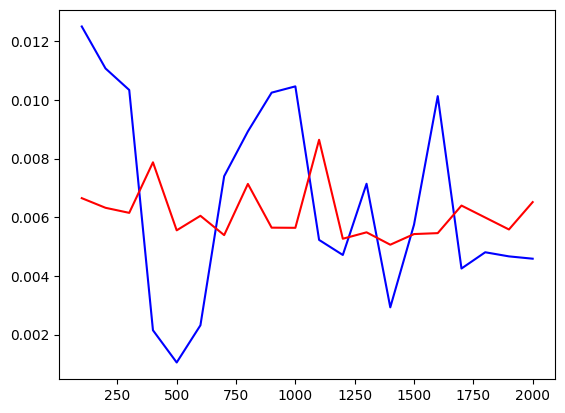

In [7]:
plt.plot(iteration_array, loss_array, 'blue')
plt.plot(iteration_array, val_loss_array, 'red')


#weight decay

9.830999999999998
7.773666666666667


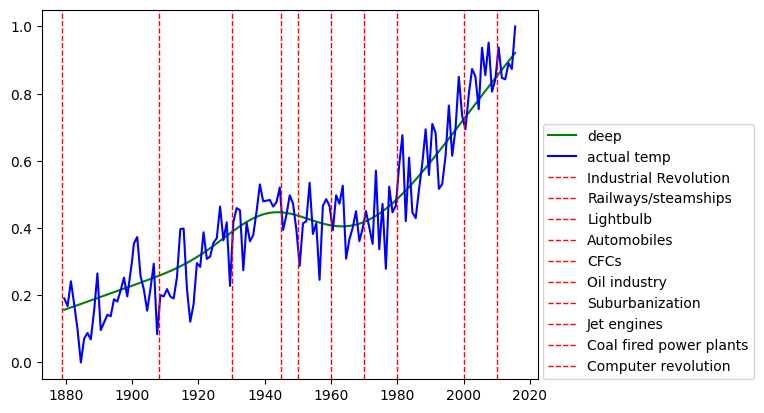

In [8]:
#Important historical dates for innovation
#1760 - Industrial revolution begins
#1800 - Expansion of railways and steamships
#1879 - Invention of the lightbulb
#1908 - Mass production of automobiles
#1930 - Developement of synthetic chemicals (CFCs)
#1945 - Rise of the oil industry
#1950 - Expansion of the Suburbs
#1960 - Introduction of jet engines
#1970 - Introduction of coal fired power plants
#1980 - Advent of computer and digital revolution
#2000 - Expansion of the internet and Data centres (internet, cloud computing etc)
#2010 - Rise of cryptocurrencies

div = 1

#max_temp = poly_model.forward(torch.tensor(max(y_data), dtype = torch.float32).reshape(-1,1,1)).detach().numpy()[0][0]
#min_temp = poly_model.forward(torch.tensor(min(y_data), dtype = torch.float32).reshape(-1,1,1)).detach().numpy()[0][0]
max_temp = max(Cleaned_mean_temp)
min_temp = min(Cleaned_mean_temp)
print(max_temp)
print(min_temp)




#renormalise the model #convert the cumulatibe_days to years
#plt.plot(Cleaned_cummulative_days/365 + 1750 , poly_model.forward(torch.tensor(normalised_Cummulative_days, dtype = torch.float32).reshape(-1,1,1)).detach().numpy()*(max(Cleaned_mean_temp) -  min(Cleaned_mean_temp)) + min(Cleaned_mean_temp), color = "green", label = "LSTM")
#plt.plot(Cleaned_cummulative_days/365 + 1750 , Cleaned_mean_temp, color = 'blue', label = "actual temp")

plt.plot(np.array(Cleaned_cummulative_days)[::div]/365 + 1750 , poly_model.forward(torch.tensor(x_data, dtype = torch.float32).unsqueeze(-1)).detach().numpy()[::div], color = "green", label = "deep")
plt.plot(np.array(Cleaned_cummulative_days)[::div]/365 + 1750 , y_data[::div], color = 'blue', label = "actual temp")


historical_innovation = [1879,1908,1930,1945,1950,1960,1970,1980,2000,2010]#[1760,1800,1879,1908,1930,1945,1950,1960,1970,1980,2000,2010]
innovation_labels = ['Industrial Revolution', 'Railways/steamships', 'Lightbulb', 'Automobiles', 
                     'CFCs', 'Oil industry', 'Suburbanization', 'Jet engines', 'Coal fired power plants', 'Computer revolution', 'Internet expansion', 'Cryptocurrencies']
colors = ['red']
for x, label in zip(historical_innovation, innovation_labels):#, colors):
    plt.axvline(x=x, color='red', linestyle='--', linewidth=1, label = label)

plt.legend(loc = (1.01,0))


In [9]:
#nlp sentiment analysis from press conference. 

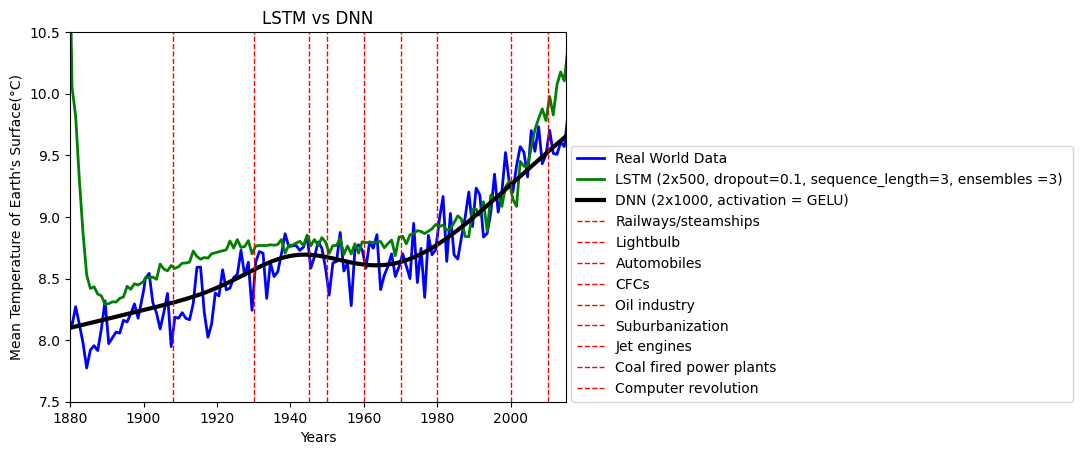